In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19,preprocess_input,decode_predictions

In [3]:
import shutil
import random

# Set your dataset root folder and split ratio
dataset_root = "C:/Users/wwwaa/ml/Untitled Folder/final mini project sem 5/archive (5)/color/"
train_ratio = 0.8  # 80% of data for training, adjust as needed

# Check if train and test folders already exist
train_folder = os.path.join(dataset_root, "train")
test_folder = os.path.join(dataset_root, "val")

if not os.path.exists(train_folder) and not os.path.exists(test_folder):
    # Create train and test folders if they don't exist
    os.makedirs(train_folder)
    os.makedirs(test_folder)

    # Loop through each class folder in the dataset
    for class_folder in os.listdir(dataset_root):
        if os.path.isdir(os.path.join(dataset_root, class_folder)):
            class_path = os.path.join(dataset_root, class_folder)
            train_class_path = os.path.join(train_folder, class_folder)
            test_class_path = os.path.join(test_folder, class_folder)

            # Create class-specific train and test folders
            os.makedirs(train_class_path)
            os.makedirs(test_class_path)

            # List all image files in the class folder
            images = [f for f in os.listdir(class_path) if f.lower().endswith((".jpg", ".jpeg", ".png"))]

            # Shuffle the list of images
            random.shuffle(images)

            # Split the images into train and test sets
            num_train = int(train_ratio * len(images))
            train_images = images[:num_train]
            test_images = images[num_train:]

            # Move train images to the train folder
            for image in train_images:
                src = os.path.join(class_path, image)
                dst = os.path.join(train_class_path, image)
                shutil.copy(src, dst)

            # Move test images to the test folder
            for image in test_images:
                src = os.path.join(class_path, image)
                dst = os.path.join(test_class_path, image)
                shutil.copy(src, dst)

    print("Dataset split into train and test sets successfully.")
else:
    print("Train and test folders already exist. Skipping dataset splitting.")



Train and test folders already exist. Skipping dataset splitting.


In [4]:
train_datagen=ImageDataGenerator(zoom_range=0.5,shear_range=0.3,horizontal_flip=True,preprocessing_function=preprocess_input)
val_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)

In [5]:
train=train_datagen.flow_from_directory(directory="C:/Users/wwwaa/ml/Untitled Folder/final mini project sem 5/archive (5)/color/train",target_size=(255,255),batch_size=32)
val=val_datagen.flow_from_directory(directory="C:/Users/wwwaa/ml/Untitled Folder/final mini project sem 5/archive (5)/color/val",target_size=(255,255),batch_size=32)


Found 43429 images belonging to 40 classes.
Found 10876 images belonging to 40 classes.


In [6]:
t_img,label=train.next()

In [7]:
t_img.shape

(32, 255, 255, 3)

In [8]:
def plotImage(img_arr,label):
  for im,l in zip(img_arr,label):
    plt.figure(figsize=(5,5))
    plt.imshow(im/255)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


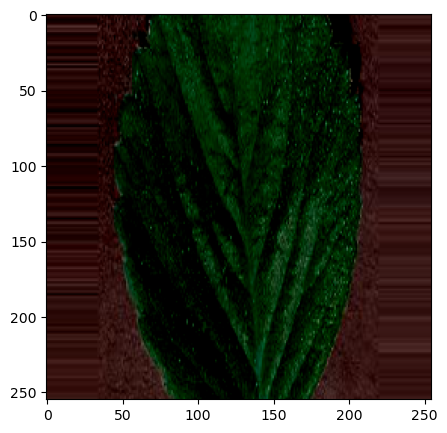

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


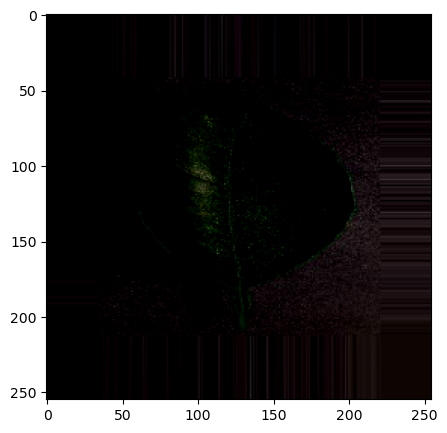

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


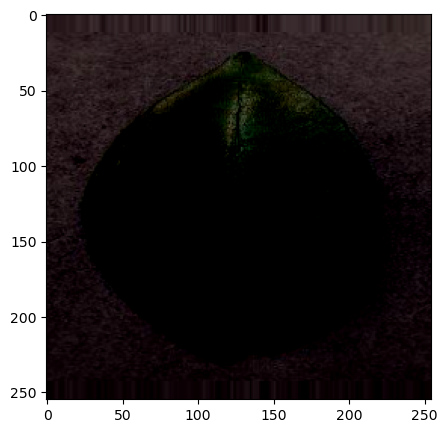

In [9]:
plotImage(t_img[:3],label[:3])

## ***Model***






In [10]:
from keras.layers import Dense,Flatten
from keras.models import Model

In [11]:
from keras.applications import vgg16
base_model=VGG19(input_shape=(255,255,3),include_top=False)

In [12]:
for layer in base_model.layers:
  layer.trainable=False

In [13]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 255, 255, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 255, 255, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 255, 255, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 127, 127, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 127, 127, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 127, 127, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 63, 63, 128)       0     

In [14]:
x=Flatten()(base_model.output)
x=Dense(units=40,activation='softmax')(x)

In [15]:
model=Model(base_model.input,x)

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 255, 255, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 255, 255, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 255, 255, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 127, 127, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 127, 127, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 127, 127, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 63, 63, 128)       0     

### ***COMPILE MODEL ***

In [17]:
model.compile(optimizer='adam',loss=keras.losses.categorical_crossentropy,metrics=['accuracy'])

### ***Earlystopping and checkpoint ***

In [18]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

es=EarlyStopping(monitor='val_accuracy',min_delta=0.01,patience=3,verbose=1)
mc=ModelCheckpoint(filepath="C:/Users/wwwaa/ml/Untitled Folder/final mini project sem 5/archive (5)/best_model1.h5",
                   monitor='val_accuracy',
                   min_delta=0.01,patience=3,verbose=1,
                   save_best_only=True)
cb=[es,mc]

### ***TRAIN MODEL ***

In [19]:
history=model.fit_generator(train,steps_per_epoch=16,epochs=50,verbose=1,callbacks=cb,validation_data=val,validation_steps=16)

C:\Users\wwwaa\AppData\Local\Temp\ipykernel_22088\3920267427.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train,steps_per_epoch=16,epochs=50,verbose=1,callbacks=cb,validation_data=val,validation_steps=16)


Epoch 1/50
16/16 [==============================] - ETA: 0s - loss: 16.2569 - accuracy: 0.3164
Epoch 1: val_accuracy improved from -inf to 0.53711, saving model to C:/Users/wwwaa/ml/Untitled Folder/final mini project sem 5/archive (5)\best_model1.h5
16/16 [==============================] - 144s 9s/step - loss: 16.2569 - accuracy: 0.3164 - val_loss: 9.8466 - val_accuracy: 0.5371
Epoch 2/50
16/16 [==============================] - ETA: 0s - loss: 9.4215 - accuracy: 0.5547
Epoch 2: val_accuracy improved from 0.53711 to 0.65820, saving model to C:/Users/wwwaa/ml/Untitled Folder/final mini project sem 5/archive (5)\best_model1.h5
16/16 [==============================] - 143s 9s/step - loss: 9.4215 - accuracy: 0.5547 - val_loss: 7.4678 - val_accuracy: 0.6582
Epoch 3/50
16/16 [==============================] - ETA: 0s - loss: 8.4546 - accuracy: 0.6074
Epoch 3: val_accuracy improved from 0.65820 to 0.69531, saving model to C:/Users/wwwaa/ml/Untitled Folder/final mini project sem 5/archive (5)\

In [20]:
h=history.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

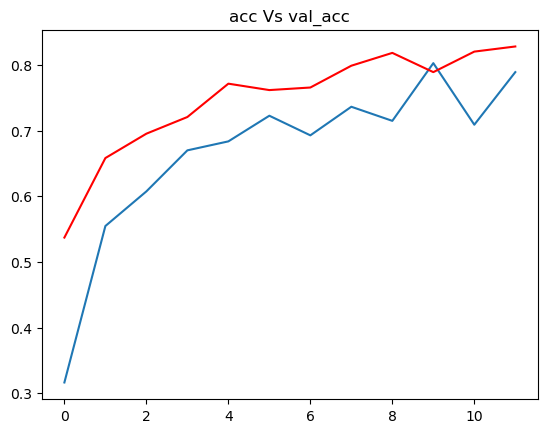

In [21]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'],c="red")
plt.title("acc Vs val_acc")
plt.show()

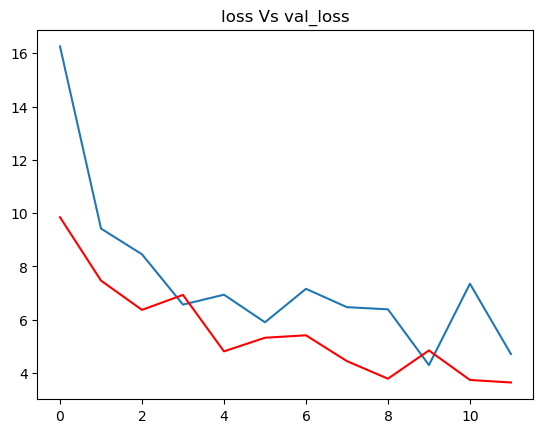

In [22]:
plt.plot(h['loss'])
plt.plot(h['val_loss'],c="red")
plt.title("loss Vs val_loss")
plt.show()

### ***CALCULATING ACCURACY ***

In [23]:
from keras.saving.legacy.save import load_model
model=load_model("C:/Users/wwwaa/ml/Untitled Folder/final mini project sem 5/archive (5)/best_model1.h5")

In [24]:
acc=model.evaluate(val)[1]
print(f"The accuracy of your model is {acc*100}%")

340/340 [==============================] - 983s 3s/step - loss: 3.5292 - accuracy: 0.8407
The accuracy of your model is 84.06583070755005%


### ***TEST WITH SAMPLE ***

In [25]:
ref={0: 'Apple Applescab',
1: 'Apple Blackrot',
2: 'Apple  Cedarapple rust',
3: 'Apple  healthy'  ,
4: 'Blueberry  healthy',
5: 'Cherry  Powderymildew' ,
6: 'Cherry healthy' ,
7: 'Corn Cercospora leafspot Gray leafspot',
8: 'Corn Common rust ',
9: 'Corn  Northern LeafBlight' ,
10: 'Corn (maize) healthy',
11: 'Grape  Blackrot'  ,
12: 'Grape  Esca(Black Measles)',
13: 'Grape  Leafblight (IsariopsisLeaf Spot)',
14: 'Grape  healthy'  ,
15: 'Orange  Haunglongbing(Citrus greening)' ,
16: 'Peach  Bacterialspot'  ,
17: 'Peach  healthy'  ,
18: 'Pepper bell Bacterial spot' ,
19: 'Pepper bell healthy'  ,
20: 'Potato  Earlyblight',
21: 'Potato  Lateblight'  ,
22: 'Potato  healthy'  ,
23: 'Raspberry  healthy',
24: 'Soybean  healthy'  ,
25: 'Squash  Powdery mildew' ,
26: 'Strawberry  Leafscorch' ,
27: 'Strawberry  healthy' ,
28: 'Tomato  Bacterialspot',
29: 'Tomato  Earlyblight' ,
30: 'Tomato  Lateblight' ,
31: 'Tomato  LeafMold'  ,
32: 'Tomato  Septorialeaf spot' ,
33: 'Tomato  Spidermites Two-spotted spidermite' ,
34: 'Tomato  TargetSpot'  ,
35: 'Tomato  Yellow LeafCurl Virus',
36: 'Tomato  mosaicvirus'  ,
37: 'Tomato healthy'    }

In [26]:
from PIL import Image
import numpy as np

def prediction(path):
    # Open the image using PIL
    img = Image.open(path)

    # Resize the image to the target size (255x255)
    img = img.resize((255, 255))

    # Convert the image to a numpy array
    i = np.array(img)

    # Preprocess the input image for the model
    im = preprocess_input(i)

    # Expand dimensions to match the model's input shape
    img = np.expand_dims(im, axis=0)

    # Make a prediction using the provided model
    pred = np.argmax(model.predict(img))

    # Print the prediction result

    print (f"The image belongs to {ref[pred]}")

# Your code here



In [27]:
path="C:/Users/wwwaa/ml/Untitled Folder/final mini project sem 5/archive (5)/color/val/Peach___Bacterial_spot/025fdbf8-0339-4821-b788-d2a92b974d31___Rutg._Bact.S 2047.JPG"
prediction(path)

1/1 [==============================] - 0s 269ms/step
The image belongs to Peach  Bacterialspot


In [28]:
print("Thank you")

Thank you
